# NER with PEFT

In this notebook we will perform PEFT for a token classification task on the CoNLLpp dataset.

In [1]:
import json
import wandb
import torch
import random
import numpy as np
import pandas as pd

In [2]:
import seqeval
import evaluate
from datasets import load_dataset, Dataset

import transformers
from transformers import pipeline
from transformers import AutoTokenizer
from transformers import AutoModelForTokenClassification
from transformers import DataCollatorForTokenClassification
from transformers import TrainingArguments, Trainer

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
sns.set_theme("notebook")
sns.set_style("dark")

In [4]:
# fix random seed
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
transformers.set_seed(seed)

In [5]:
project_name = "PEFT-NER"
access_tokens_path = "./data/access_tokens.json"
model_ckpt = "distilbert-base-cased"
data_ckpt = "conllpp"

model_name = f"{model_ckpt}-finetuned-{data_ckpt}-adapters"
model_path = f"./models/{model_name}"

In [6]:
raw_datasets = load_dataset("conllpp")

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [7]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})

In [8]:
cols_to_remove = ["id", "pos_tags", "chunk_tags"]  # used for conll datasets

In [9]:
raw_datasets = raw_datasets.remove_columns(cols_to_remove)

In [10]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 3453
    })
})

In [11]:
label_names = raw_datasets["train"].features["ner_tags"].feature.names
label_names

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']

In [12]:
tokenizer = AutoTokenizer.from_pretrained(model_ckpt, add_prefix_space=True)

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [13]:
def align_labels_to_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            current_word = word_id
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            new_labels.append(-100)
        else:
            label = labels[word_id]
            if label % 2 == 1:
                label += 1
            new_labels.append(label)
    return new_labels

In [14]:
def tokenize_and_align_labels(batch):
    tokenized_inputs = tokenizer(
        batch["tokens"], is_split_into_words=True, truncation=True
    )

    new_labels = []
    all_labels = batch["ner_tags"]
    for i, labels in enumerate(all_labels):
        new_labels.append(align_labels_to_tokens(labels, tokenized_inputs.word_ids(i)))

    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs

In [15]:
tokenized_datasets = raw_datasets.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=raw_datasets["train"].column_names,
)

Map:   0%|          | 0/14041 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

In [16]:
metric = evaluate.load("seqeval")

In [17]:
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    preds = np.argmax(logits, axis=-1)

    clean_labels = [[label_names[l] for l in ls if l != -100] for ls in labels]
    clean_preds = [
        [label_names[p] for (p, l) in zip(ps, ls) if l != -100]
        for (ps, ls) in zip(preds, labels)
    ]

    metrics = metric.compute(predictions=clean_preds, references=clean_labels)
    overall_metrics = {
        "accuracy": metrics["overall_accuracy"],
        "precision": metrics["overall_precision"],
        "recall": metrics["overall_recall"],
        "f1": metrics["overall_f1"],
    }
    return overall_metrics

In [18]:
id2label = {i: label for i, label in enumerate(label_names)}
label2id = {v: k for k, v in id2label.items()}

In [19]:
from adapters import AutoAdapterModel, init, AdapterConfig

In [20]:
model = AutoAdapterModel.from_pretrained(
    model_ckpt,
)

model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

In [21]:
print(model.adapter_summary())

Name                     Architecture         #Param      %Param  Active   Train
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Full model                                65,190,912     100.000               1


In [22]:
adapter_config = AdapterConfig.load("lora", r=8, alpha=32)

In [23]:
model.add_adapter("conllpp_lora", config=adapter_config)

In [24]:
print(model.adapter_summary())

Name                     Architecture         #Param      %Param  Active   Train
--------------------------------------------------------------------------------
conllpp_lora             lora                147,456       0.226       0       1
--------------------------------------------------------------------------------
Full model                                65,190,912     100.000               1


In [25]:
model.add_tagging_head("conllpp_head", num_labels=len(label_names), id2label=id2label)

In [26]:
print(model.adapter_summary())

Name                     Architecture         #Param      %Param  Active   Train
--------------------------------------------------------------------------------
conllpp_lora             lora                147,456       0.226       0       1
--------------------------------------------------------------------------------
Full model                                65,190,912     100.000               1


In [27]:
model.set_active_adapters(["conllpp_lora"])

In [28]:
model.train_adapter(["conllpp_lora"])

In [29]:
print(model.adapter_summary())

Name                     Architecture         #Param      %Param  Active   Train
--------------------------------------------------------------------------------
conllpp_lora             lora                147,456       0.226       1       1
--------------------------------------------------------------------------------
Full model                                65,190,912     100.000               0


In [30]:
print(model.get_labels_dict())

{0: 'O', 1: 'B-PER', 2: 'I-PER', 3: 'B-ORG', 4: 'I-ORG', 5: 'B-LOC', 6: 'I-LOC', 7: 'B-MISC', 8: 'I-MISC'}


In [31]:
with open(access_tokens_path) as f:
    login_key = json.load(f)["wandb"]["login"]

wandb.login(key=login_key)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [32]:
wandb.init(project=project_name, name=model_name)

wandb: Currently logged in as: e_hossam96. Use `wandb login --relogin` to force relogin
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [33]:
args = TrainingArguments(
    model_path,
    overwrite_output_dir=True,
    num_train_epochs=5,
    load_best_model_at_end=True,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    report_to="wandb",
    seed=seed,
    data_seed=seed,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    learning_rate=1e-4,
    weight_decay=1e-3,
    warmup_ratio=0.05,
)

In [34]:
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [35]:
from adapters import AdapterTrainer

trainer = AdapterTrainer(
    model=model,
    args=args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

In [36]:
trainer.train()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.192600,0.179844,0.945561,0.690236,0.793504,0.738276
2,0.152000,0.137431,0.959395,0.777673,0.834736,0.805195
3,0.123600,0.129269,0.963016,0.809057,0.847863,0.828006
4,0.123000,0.117490,0.966371,0.823812,0.866375,0.844557
5,0.130000,0.116734,0.966666,0.822088,0.869404,0.845084


Overwriting existing adapter 'conllpp_lora'.


TrainOutput(global_step=17555, training_loss=0.19836220039122127, metrics={'train_runtime': 692.8815, 'train_samples_per_second': 101.323, 'train_steps_per_second': 25.336, 'total_flos': 654823165252974.0, 'train_loss': 0.19836220039122127, 'epoch': 5.0})

In [37]:
trainer.evaluate(tokenized_datasets["test"], metric_key_prefix="test")

{'test_loss': 0.1585155725479126,
 'test_accuracy': 0.9569972108854257,
 'test_precision': 0.7984778292521509,
 'test_recall': 0.8463696948439144,
 'test_f1': 0.8217265452068789,
 'test_runtime': 15.5185,
 'test_samples_per_second': 222.509,
 'test_steps_per_second': 55.676,
 'epoch': 5.0}

In [38]:
outs = trainer.predict(tokenized_datasets["test"])
preds, labels = outs.predictions, outs.label_ids
preds = preds.argmax(axis=-1)
clean_labels = [[label_names[l] for l in ls if l != -100] for ls in labels]
clean_preds = [
    [label_names[p] for (p, l) in zip(ps, ls) if l != -100]
    for (ps, ls) in zip(preds, labels)
]

In [39]:
print(
    seqeval.metrics.classification_report(
        clean_labels,
        clean_preds,
    )
)

              precision    recall  f1-score   support

         LOC       0.83      0.90      0.86      1646
        MISC       0.58      0.69      0.63       723
         ORG       0.76      0.78      0.77      1715
         PER       0.92      0.94      0.93      1618

   micro avg       0.80      0.85      0.82      5702
   macro avg       0.77      0.83      0.80      5702
weighted avg       0.80      0.85      0.82      5702



In [40]:
all_labels = []
all_preds = []
for l, p in zip(clean_labels, clean_preds):
    all_labels.extend(l)
    all_preds.extend(p)

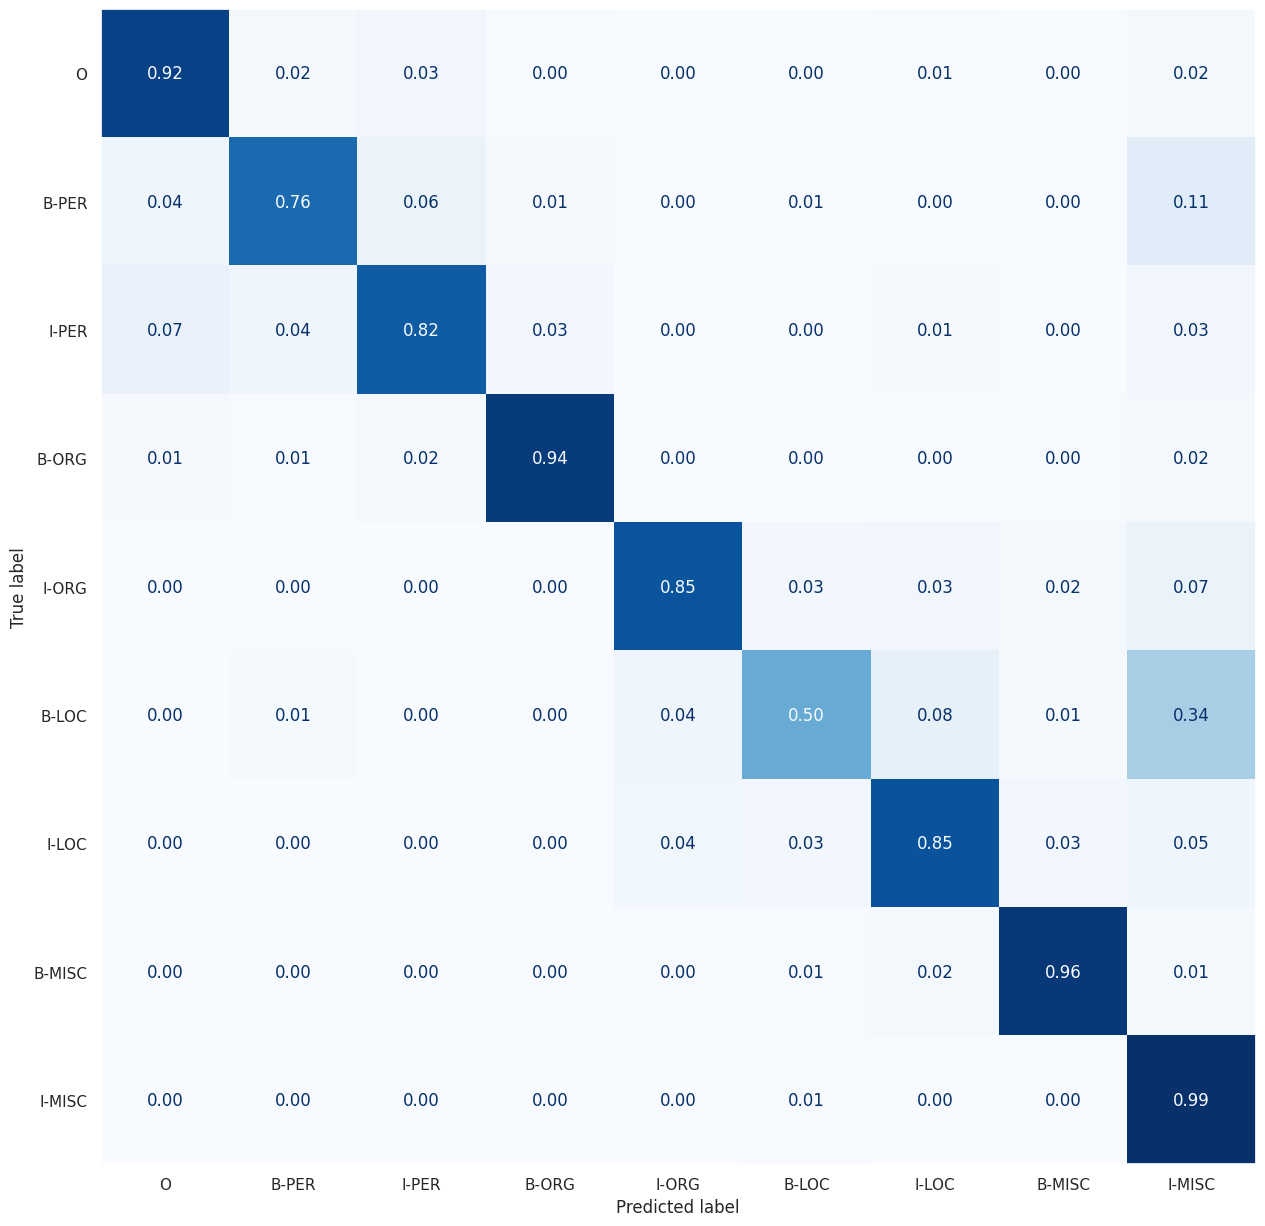

<Figure size 640x480 with 0 Axes>

In [41]:
_, ax = plt.subplots(figsize=(15, 15))
cm = confusion_matrix(
    all_labels,
    all_preds,
    normalize="true",
)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)

disp.plot(cmap="Blues", colorbar=False, ax=ax, values_format=".2f")
plt.show()
plt.tight_layout()

In [42]:
trainer.save_model(model_path)

In [43]:
wandb.finish()

eval/accuracy,▁▆▇██
eval/f1,▁▅▇██
eval/loss,█▃▂▁▁
eval/precision,▁▆▇██
eval/recall,▁▅▆██
eval/runtime,▁▄▅█▇
eval/samples_per_second,█▅▃▁▂
eval/steps_per_second,█▅▃▁▂
test/accuracy,▁
test/f1,▁
test/loss,▁


In [44]:
model = AutoAdapterModel.from_pretrained(model_ckpt)

In [45]:
model.load_adapter(model_path+"/conllpp_lora")

'conllpp_lora'

In [46]:
model.load_head(model_path+"/conllpp_head")

('./models/distilbert-base-cased-finetuned-conllpp-adapters/conllpp_head',
 'conllpp_head')

In [47]:
tokenizer = AutoTokenizer.from_pretrained(model_path)

In [48]:
print(model.adapter_summary())

Name                     Architecture         #Param      %Param  Active   Train
--------------------------------------------------------------------------------
conllpp_lora             lora                147,456       0.226       0       1
--------------------------------------------------------------------------------
Full model                                65,190,912     100.000               1


In [49]:
model.set_active_adapters(["conllpp_lora"])

In [50]:
print(model.adapter_summary())

Name                     Architecture         #Param      %Param  Active   Train
--------------------------------------------------------------------------------
conllpp_lora             lora                147,456       0.226       1       1
--------------------------------------------------------------------------------
Full model                                65,190,912     100.000               1


In [51]:
ner = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple")

The model 'DistilBertAdapterModel' is not supported for ner. Supported models are ['AlbertForTokenClassification', 'BertForTokenClassification', 'BigBirdForTokenClassification', 'BioGptForTokenClassification', 'BloomForTokenClassification', 'BrosForTokenClassification', 'CamembertForTokenClassification', 'CanineForTokenClassification', 'ConvBertForTokenClassification', 'Data2VecTextForTokenClassification', 'DebertaForTokenClassification', 'DebertaV2ForTokenClassification', 'DistilBertForTokenClassification', 'ElectraForTokenClassification', 'ErnieForTokenClassification', 'ErnieMForTokenClassification', 'EsmForTokenClassification', 'FalconForTokenClassification', 'FlaubertForTokenClassification', 'FNetForTokenClassification', 'FunnelForTokenClassification', 'GPT2ForTokenClassification', 'GPT2ForTokenClassification', 'GPTBigCodeForTokenClassification', 'GPTNeoForTokenClassification', 'GPTNeoXForTokenClassification', 'IBertForTokenClassification', 'LayoutLMForTokenClassification', 'Layout

In [52]:
ner("I love Egypt")

[{'entity_group': 'LOC',
  'score': 0.9860162,
  'word': 'Egypt',
  'start': 7,
  'end': 12}]

In [53]:
from spacy import displacy
from IPython.display import HTML

In [54]:
def create_scheme(text, outs):
    scheme = {}
    scheme["text"] = text
    scheme["ents"] = [
        {"start": ent["start"], "end": ent["end"], "label": ent["entity_group"]}
        for ent in outs
    ]
    scheme["title"] = None
    return scheme

In [55]:
index = 10
text = " ".join(raw_datasets["train"]["tokens"][index])
outs = ner(text)

In [57]:
_ = HTML(displacy.render(create_scheme(text, outs), style="ent", manual=True))